# Analyze 5on5 Shift Data
Now that we have mined ice time by each line by each game, we can begin answering the question: Which teams give the most ice time to their top line?

In [1]:
import pandas as pd
import numpy as np
import matplotlib as plt
import requests
import json
import pprint

##### Read in Data

In [2]:
df = pd.read_csv('../data/shifts_forwards_5on5.csv', index_col=0)

In [3]:
df

,gameId,teamId,lineId,seconds,numFwds
42,2020020001,5,8471675_8477404_8478542,815,3
33,2020020001,5,8471215_8475722_8475810,735,3
20,2020020001,4,8476461_8478067_8478439,722,3
7,2020020001,4,8474037_8474161_8479974,686,3
3,2020020001,4,8473512_8475763_8480797,681,3
...,...,...,...,...,...
36,2021020401,54,8474149_8476448_8477406,5,3
50,2021020401,54,8475913_8477406_8477478_8478434,4,4
17,2021020401,25,8471228_8478449_8480027,4,3
35,2021020401,54,8474149_8475191_8476448_8476539,3,4


##### Assign Line Classification
Without ongoing discussion between stakeholders (GMs and coaches) and developers on how to classify a team's 1st line, 2nd line, ..., we will simply assign the line with the most icetime in a game as the team's 1st line. The line with the next most icetime in that game will be classified as the team's 2nd line.

A team's line combination will change game by game. Therefore, it is important to classify line ranking on a game by game basis, and then compare usage of lines. For example, the Hurricanes 1st line has seen a few combinations this season: Svechnikov-Aho-Teravainen, Jarvis-Aho-Teravainen, Niederreiter-Aho-Teravainen, Niederreiter-Aho-Necas, Martinook-Aho-Jarvis. And often times, it is not always one of these '1st' lines that gets the most icetime. Therefore, we must classify line ranking inside each game, and then compare overall line usage.

Other methods of classifying a 'top line' is the presence of a certain players (i.e. naming the Blackhawks Patrick Kane line as the 1st line every game no matter how much 5on5 icetime his line gets). Also, classifying line ranking by the number of faceoffs started by a line is an option. These classification methods can be explored in later work.

In [4]:
df = df.sort_values(['gameId', 'teamId', 'seconds'], ascending=False)

# calculate ranking of icetime received for this line combination
df['lineRank'] = 1
df['lineRank'] = df.groupby(['gameId', 'teamId'])['lineRank'].cumsum()

# if lineRank is more than 4, classify this combination of players as an empty-net-situation or a line-change
df['lineId'] = np.where((df['lineRank']>4) & (df['numFwds']>=5), 'empty_net_situation', 
                        np.where(df['lineRank']>4, 'line_change', df['lineId'])
                       )

# calculate total time used to change lines / empty net situation
df = df.groupby(['gameId', 'teamId', 'lineId']).sum().reset_index()

# conditionally rename misc. line combos
df['lineRank'] = np.where(df['lineId'] == 'line_change', 5, 
                          np.where(df['lineId'] == 'empty_net_situation', 6, df['lineRank'])
                         )
df = df.sort_values(['gameId', 'teamId', 'lineRank'])

In [5]:
df[(df['gameId']==2021020001)]
# df_tmp

,gameId,teamId,lineId,seconds,numFwds,lineRank
8990,2021020001,5,8470604_8475810_8478046,939,3,1
8992,2021020001,5,8475722_8477953_8478542,772,3,2
8993,2021020001,5,8476927_8476934_8478866,687,3,3
8991,2021020001,5,8470619_8478043_8482055,447,3,4
8994,2021020001,5,line_change,512,72,5
8998,2021020001,14,8476292_8476453_8478010,769,3,1
8996,2021020001,14,8473986_8474564_8478519,706,3,2
8995,2021020001,14,8470621_8477930_8479390,302,3,3
8997,2021020001,14,8474034_8478472_8479525,263,3,4
9000,2021020001,14,line_change,1254,90,5


##### Calculate Proportion of Time Used by Top Line in each Game

In [6]:
# pivot df
df_p = df.pivot(index=['gameId', 'teamId'], columns='lineRank', values='seconds').reset_index()

# fill NaN values for lineRank==6
df_p.fillna(0, inplace=True)

df_p.head()

lineRank,gameId,teamId,1,2,3,4,5,6
0,2020020001,4,722.0,686.0,681.0,591.0,611.0,0.0
1,2020020001,5,815.0,735.0,596.0,568.0,577.0,0.0
2,2020020002,14,767.0,707.0,659.0,476.0,498.0,0.0
3,2020020002,16,526.0,511.0,501.0,484.0,552.0,533.0
4,2020020003,8,655.0,517.0,483.0,343.0,1012.0,168.0


In [7]:
# calculate total 5on5 time for each game
df_p['totalExcludingLineChange'] = df_p[1] + df_p[2] + df_p[3] + df_p[4]
df_p['total'] = df_p['totalExcludingLineChange'] + df_p[5] + df_p[6]

# calculate proportion of time line 1 is used
df_p['line1UsageExcludingLineChange'] = df_p[1] / df_p['totalExcludingLineChange']
df_p['line1Usage'] = df_p[1] / df_p['total']
df_p['line2UsageExcludingLineChange'] = df_p[2] / df_p['totalExcludingLineChange']

In [8]:
df_p.head()

lineRank,gameId,teamId,1,2,3,4,5,6,totalExcludingLineChange,total,line1UsageExcludingLineChange,line1Usage,line2UsageExcludingLineChange
0,2020020001,4,722.0,686.0,681.0,591.0,611.0,0.0,2680.0,3291.0,0.269403,0.219386,0.255970
1,2020020001,5,815.0,735.0,596.0,568.0,577.0,0.0,2714.0,3291.0,0.300295,0.247645,0.270818
2,2020020002,14,767.0,707.0,659.0,476.0,498.0,0.0,2609.0,3107.0,0.293982,0.246862,0.270985
3,2020020002,16,526.0,511.0,501.0,484.0,552.0,533.0,2022.0,3107.0,0.260138,0.169295,0.252720
4,2020020003,8,655.0,517.0,483.0,343.0,1012.0,168.0,1998.0,3178.0,0.327828,0.206104,0.258759


##### Calculate Top Line Usage by Team
For the rest of this analysis, we will focus on the proportion of top line usage generated excluding time taken for line changes.

Additionally, we will focus on describing a team's typical top line usage with median. After working with this data for some time, it is obvious there are data entry errors, and values such as mean are impacted greater by these errors. So let's stick with median, which is more resilant against influential data entry errors.

In [9]:
# calculate median
df_usage = df_p[['teamId', 'line1UsageExcludingLineChange', 'line2UsageExcludingLineChange']].groupby('teamId').median().reset_index()
df_usage = df_usage.sort_values('line1UsageExcludingLineChange', ascending=False)

In [10]:
# mine team names
r = requests.get(url='https://statsapi.web.nhl.com/api/v1/teams')
d = r.json()

teams_and_ids = [{
    'teamId': t['id'],
    'name': t['name']
} for t in d['teams']]

df_teams = pd.DataFrame(teams_and_ids)

In [11]:
df_usage = df_usage.merge(df_teams, on='teamId')
df_usage.head(10)

,teamId,line1UsageExcludingLineChange,line2UsageExcludingLineChange,name
0,21,0.357396,0.261089,Colorado Avalanche
1,5,0.350792,0.272027,Pittsburgh Penguins
2,9,0.350541,0.273142,Ottawa Senators
3,55,0.344912,0.279554,Seattle Kraken
4,16,0.344633,0.260833,Chicago Blackhawks
5,22,0.342071,0.278956,Edmonton Oilers
6,17,0.339551,0.265918,Detroit Red Wings
7,52,0.336012,0.278651,Winnipeg Jets
8,23,0.332459,0.272807,Vancouver Canucks
9,19,0.328961,0.274619,St. Louis Blues


Text(0, 0.5, 'Proportion of Usage')

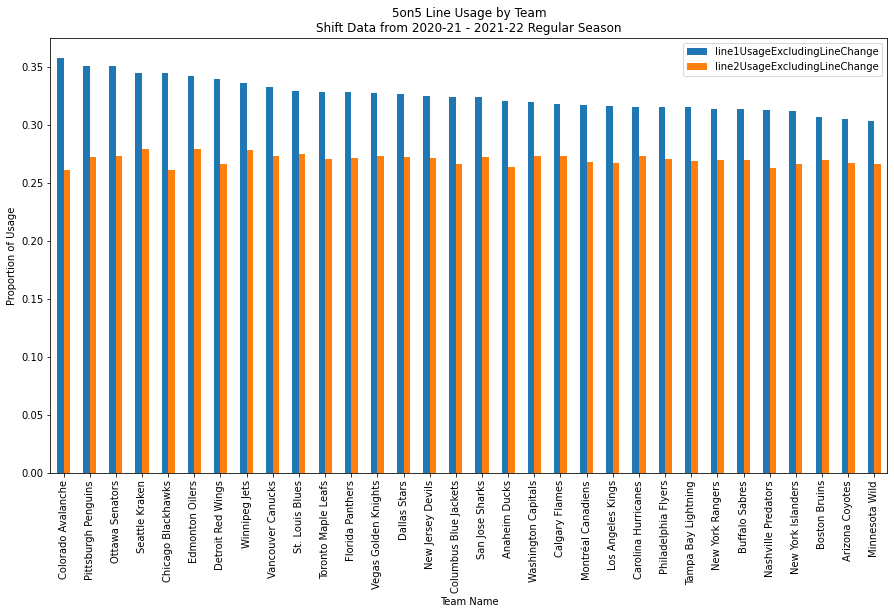

In [12]:
ax = df_usage.plot.bar(x='name', 
                       y=['line1UsageExcludingLineChange', 'line2UsageExcludingLineChange'],
                       title='5on5 Line Usage by Team\nShift Data from 2020-21 - 2021-22 Regular Season',
                       figsize=(15, 8))
ax.set_xlabel("Team Name")
ax.set_ylabel("Proportion of Usage")

